# Quickstart AltaiPony: De-trend and find flares

Let's first get the base class and the IO function we want to use:

In [1]:
from altaipony.flarelc import FlareLightCurve
from altaipony.lcio import from_mast

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Now download a **K2SC** light curve from archive and create a ``FlareLightCurve``.


In [2]:
EPIC = 211983544
# c is the campaign for K2, sector for TESS, and quarter for Kepler
flc = from_mast(EPIC, mode="TPF", mission="K2", c=18)

Loading KWallet
Loading SecretService
Loading Windows
Loading chainer
Loading macOS
Loading KWallet
Loading SecretService
Loading Windows
Loading chainer
Loading macOS
/usr/lib64/python3.6/importlib/_bootstrap_external.py:556: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1973/bus>
  spec = _bootstrap.ModuleSpec(name, loader, origin=location)
/usr/lib64/python3.6/importlib/_bootstrap_external.py:556: ResourceWarning: unclosed <socket.socket fd=59, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1973/bus>
  spec = _bootstrap.ModuleSpec(name, loader, origin=location)
/usr/lib64/python3.6/importlib/_bootstrap_external.py:556: ResourceWarning: unclosed <socket.socket fd=60, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1973/bus>
  spec = _bootstrap.ModuleSpec(name, loader, origin=location)
/usr/lib64/python3.6/importlib/_bootstrap_e

Let's verify that we succeeded:

In [3]:
flc

FlareLightCurve(ID: 211983544)

The representation tells us that we have indeed created a ``FlareLightCurve``.

Now let's look at some cool tools we inherited from the awesome [``lightkurve``](https://github.com/KeplerGO/lightkurve) package:

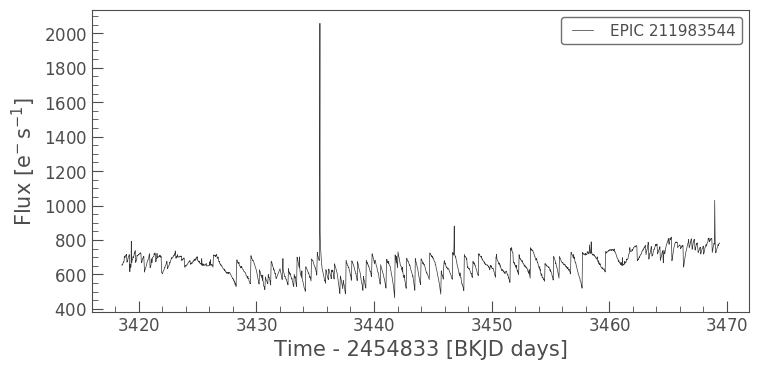

In [4]:
flc.plot();

This is the raw light curve. The is intrumental noise but also stellar variability. Let's remove it with K2SC:

In [5]:
flc = flc.detrend("k2sc")

Starting initial outlier detection at 3sigma.
iteration 1 at normalized median flux1.00000 \pm 0.01695
iteration 2 at normalized median flux1.00009 \pm 0.01653
iteration 3 at normalized median flux1.00009 \pm 0.01650
iteration 4 at normalized median flux1.00009 \pm 0.01650
iteration 5 at normalized median flux1.00009 \pm 0.01650
iteration 6 at normalized median flux1.00009 \pm 0.01650
iteration 7 at normalized median flux1.00009 \pm 0.01650
iteration 8 at normalized median flux1.00009 \pm 0.01650
iteration 9 at normalized median flux1.00009 \pm 0.01650
iteration 10 at normalized median flux1.00009 \pm 0.01650
  Flagged 66 ( 2.8%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    1.69 (fap 3.0490e-255 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -2837.303804556527
  DE iteration %3i -ln(L) %4.1f 1 -2837.303804556527
  DE iteration %3i -ln(L) %4.1f 2 -

De-trending successfully completed.


  CDPP - raw - %6.3f 36888.75416833302
  CDPP - position component removed - %6.3f 7209.947005821045
  CDPP - full reduction - %6.3f 2396.2851933512716
Detrending time %6.3f 356.338196516037


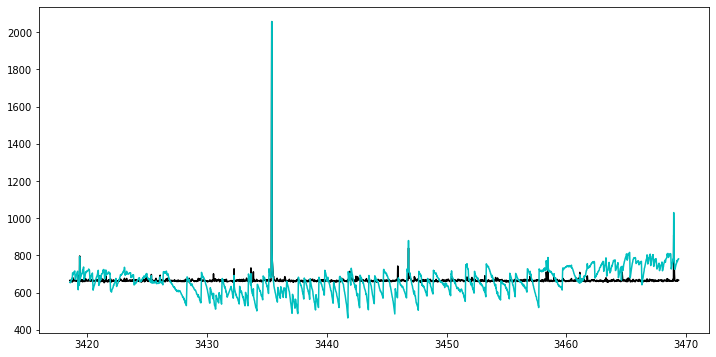

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(flc.time, flc.detrended_flux, c='k')
plt.plot(flc.time, flc.flux, c='c')

**K2SC** preserved flare signal, so this is what we use for flare finding.

So let us find the flares in this light curve (one, at least, is pretty obvious, right?)

In [7]:
flc = flc.find_flares()
flc.flares.sort_values(by="ed_rec", ascending=False)

Found 1 candidate(s) in the (0,618) gap.
Found 11 candidate(s) in the (618,2371) gap.
/home/ekaterina/Documents/001_Science/AltaiPony/appaloosa_for_tess/lib/python3.6/site-packages/pandas-0.25.1-py3.6-linux-x86_64.egg/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,tstart,tstop
2,2.095571,162792,162804,7407.022307,10.085842,775,787,3435.361892,3435.607075
11,0.368408,164437,164441,1632.682337,13.037902,2351,2354,3468.972071,3469.053797
6,0.264412,163352,163364,1082.377209,11.193440,1311,1323,3446.803711,3447.048891
4,0.075952,163113,163121,483.711411,13.993138,1080,1087,3441.920517,3442.083971
10,0.070186,164225,164229,338.634521,10.306251,2155,2159,3464.640564,3464.722291
7,0.070022,163916,163919,249.219045,8.763330,1858,1861,3458.327186,3458.388481
1,0.071795,162718,162722,242.142898,8.677861,704,708,3433.849930,3433.931658
8,0.100613,163923,163926,222.813864,6.722888,1865,1868,3458.470208,3458.531503
0,0.027854,162280,162285,164.118323,11.445737,296,301,3424.900708,3425.002868
5,0.031860,163145,163150,154.275134,10.933989,1111,1116,3442.574334,3442.676493


Aha! Some flare candidates. Let's see where they are in the light curve and zoom in on the big one:

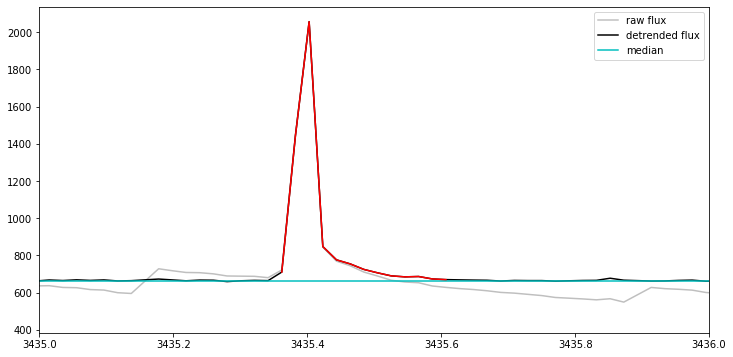

In [9]:
plt.figure(figsize=(12,6))
plt.plot(flc.time, flc.flux, c='grey', alpha=.5, label='raw flux')
plt.plot(flc.time, flc.detrended_flux, c='k', label='detrended flux')
plt.plot(flc.time, flc.it_med, c='c', label='median')
for i,f in flc.flares.iterrows():
    plt.plot(flc.time[f.istart:f.istop+1], flc.detrended_flux[f.istart:f.istop+1], c='r')
plt.xlim(3435,3436)
#plt.xlim(3464,3465) # uncomment to see a small candidate
#plt.ylim(600,900) # uncomment additionally to see a small candidate zoomed in
plt.legend();

Not all of them are real, others are real but are detected only by chance. Here is where injecting synthetic events comes in. But this is a story for a different notebook, and is a computational challenge if you wish to quantify the effects that K2SC GP de-trending has on the flare energies and recovery probabilities.

Questions? Something does not work? Email me @ eilin@aip.de 